---
title: Working with pyCATHY and DA
subtitle: PART1 - DA and SWC sensors assimilation
license: CC-BY-4.0
github: https://github.com/BenjMy/ETH_pyCATHY/
subject: Tutorial
authors:
  - name: Benjamin Mary
    email: benjamin.mary@ica.csic.es
    corresponding: true
    orcid: 0000-0001-7199-2885
    affiliations:
      - ICA-CSIC
date: 2024/04/12
---

```{toc} Table of Contents
:depth: 3
```

In [8]:
import pyCATHY
from pyCATHY import cathy_tools
import pygimli as pg

pyCATHY holds for **python** CATHY. Essentially it wraps the CATHY core to update/modify on the input files and has some **potential applications to ease preprocessing step**. pyCATHY also includes modules for Data Assimilation

In [9]:
from pyCATHY.DA.cathy_DA import DA, dictObs_2pd
from pyCATHY.DA.perturbate import perturbate_parm
from pyCATHY.DA import perturbate
from pyCATHY.DA.observations import read_observations, prepare_observations, make_data_cov
from pyCATHY.DA import performance
import pyvista as pv
import pyCATHY.plotters.cathy_plots as cplt 
import os 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# set some default plotting parameters for nicer looking plots
mpl.rcParams.update({"axes.grid":True, 
                     "grid.color":"gray", 
                     "grid.linestyle":'--',
                     'figure.figsize':(10,10)}
                   )
import pandas as pd

The notebooks does **not** describe: 
- **Preprocessing step**: build a mesh, inputs preparations, ...

The notebooks describe: 

Create [synthetic soil moisture content dataset](#fwd_mod_sol) and add [noise](#add_noise_SMC). 

1. [**Prepare for Data Assimilation**](prep_DA)
   - 2.1 Read observations
   - 2.1.2 Create covariance matrices
   - 2.2 Perturbate
   - 2.3 Define mapping operator
   
2. **Simulation**: [solve the surface-subsurface flow](#solve).

```{caution}
    Project names: 
    
      - "without DA" means that the level of noise set to the observed data is infinite (1e99) (open loop run)
        See the [import SMC section](#import_SMC_obs)
      - "with DA" with a noise level according to sensors uncertainties
      
    Choose and comment the simulation you need to run!
```

In [10]:
# Create a CATHY project
# -----------------------
simuWithDA = DA(
                        dirName='./DA_SMC',
                        prj_name= 'Weill_example_withoutDA', # without DA means that the level of noise set to data covariance is infinite (open loop run); 
                        #prj_name= 'Weill_example_withDA', 
                        notebook=True,
                    )

🏁 Initiate CATHY object

😟 src files not found

working directory 
is:/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/solution_SMC/./DA_SMC

📥 Fetch cathy src files

📥 Fetch cathy prepro src files

📥 Fetch cathy inputfiles

(fwd_mod_sol)= 
## Forward model of the solution
Run the simulation to get the model solution. This step is only necessary for this tutorial to generate synthetic observations of soil moisture content

### Change atmospheric boundary conditions

In [4]:
# Create a CATHY project
# -----------------------
simu_solution = cathy_tools.CATHY(
                                    dirName='./solution_SMC',
                                    prj_name= 'weill_dataset',
                                    notebook=True,
                                  )

🏁 Initiate CATHY object

In [5]:
simuWithDA.run_preprocessor()
simu_solution.run_preprocessor()

🍳 gfortran compilation

👟 Run preprocessor

🍳 gfortran compilation

👟 Run preprocessor

In [6]:
simuWithDA.run_processor(IPRT1=3)
simu_solution.run_processor(IPRT1=3)

🔄 update parm file 

🔄 Update hap.in file

🔄 update dem_parameters file 

🔄 update dem_parameters file 

🛠  Recompile src files [6s]

🍳 gfortran compilation [11s]

b''

👟 Run processor

🔄 update parm file 

🔄 Update hap.in file

🔄 update dem_parameters file 

🔄 update dem_parameters file 

🛠  Recompile src files [11s]

🍳 gfortran compilation [15s]

b''

👟 Run processor

In [12]:
netValue = -1e-7
rain = 4e-7
tatmbc = list(np.linspace(0,86400,10))

netValue_list = [netValue]*len(tatmbc)
netValue_list[0] = netValue + rain
netValue_list[1] = netValue + rain

In [13]:
simu_solution.update_atmbc(
                            HSPATM=1,
                            IETO=0,
                            time=tatmbc,
                            # VALUE=[None, None],
                            netValue=netValue_list,
                    )

simu_solution.update_ic(INDP=0,IPOND=0,
                        pressure_head_ini=-1,
                        )

simuWithDA.update_atmbc(
                        HSPATM=1,
                        IETO=0,
                        time=tatmbc,
                        # VALUE=[None, None],
                        netValue=netValue_list,
                )


🔄 Update atmbc

🔄 update parm file 

🔄 Update hap.in file

🔄 update dem_parameters file 

🔄 update dem_parameters file 

🔄 Update ic

🍳 gfortran compilation

👟 Run preprocessor

🔄 update parm file 

🛠  Recompile src files [888s]

🍳 gfortran compilation [893s]

b''

👟 Run processor

Single value detected for ic ==> assumming it homogeneous

🔄 Update atmbc

🔄 update parm file 

🔄 Update hap.in file

🔄 update dem_parameters file 

🔄 update dem_parameters file 

In [14]:
simu_solution.update_parm(TIMPRTi=tatmbc)
simuWithDA.update_parm(TIMPRTi=tatmbc)

# simu_solution.read_inputs('atmbc')
# simuWithDA.read_inputs('atmbc')
simu_solution.parm
simu_solution.atmbc


simu_solution.update_soil(PMIN=-1e25)
simuWithDA.update_soil(PMIN=-1e25)

🔄 update parm file 

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

['Adjusting NPRT with respect to time of interests requested\n']

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🔄 update parm file 

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

['Adjusting NPRT with respect to time of interests requested\n']

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🔄 Update soil

homogeneous soil

🔄 Update soil

homogeneous soil

In [15]:
simu_solution.run_preprocessor()
simu_solution.run_processor(IPRT1=2,
                            TRAFLAG=0
                           )

🍳 gfortran compilation

👟 Run preprocessor

🔄 update parm file 

🛠  Recompile src files [896s]

🍳 gfortran compilation [901s]

b''

👟 Run processor

### Get soil moisture data at 3 different depths

In [16]:
node_pos = [5,5,2] 
depths = [0.05,0.15,0.25,0.75]

nodeId, closest_pos = simu_solution.find_nearest_node(node_pos)

for d in depths:
    node_pos = [5,5,closest_pos[0][2]-d] 
    nodeId_tmp, closest_pos_tmp = simu_solution.find_nearest_node(node_pos)
    nodeId.append(nodeId_tmp)
    closest_pos.append(closest_pos_tmp)

nodeIds = np.vstack(nodeId)
closest_positions = np.vstack(closest_pos)
print(closest_positions)

⚠ No node close to the required points!

[[ 5.      5.      0.6675]
 [ 5.      5.      0.6075]
 [ 5.      5.      0.4875]
 [ 5.      5.      0.4275]
 [ 5.      5.     -0.1725]]


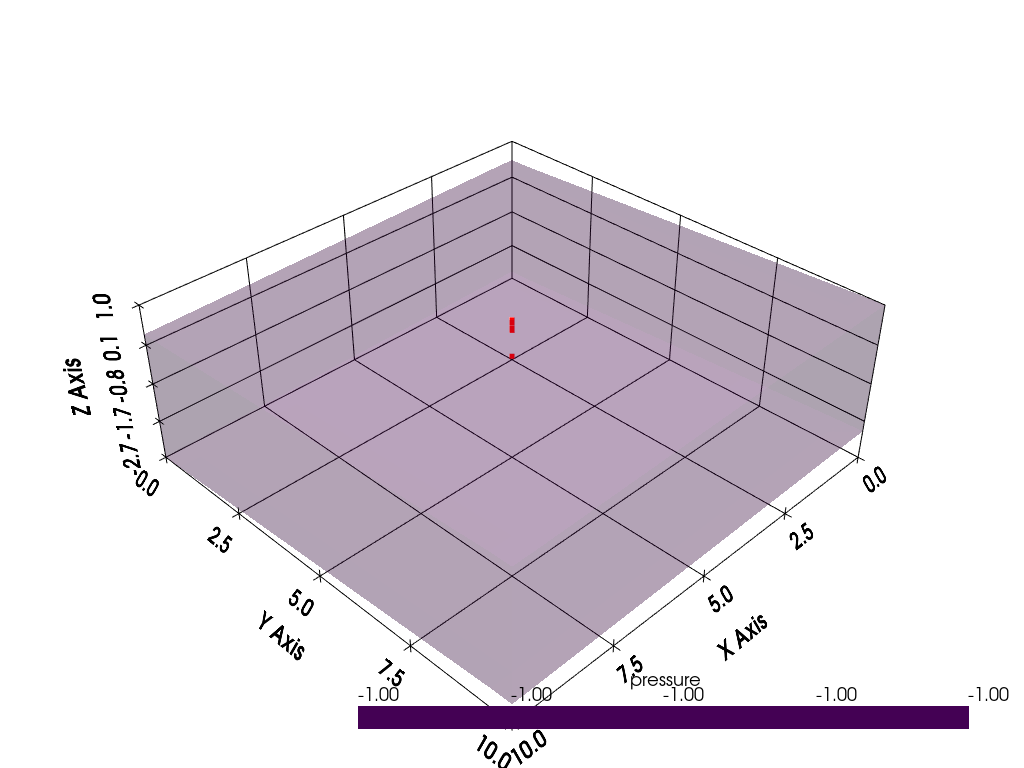

In [17]:
pl = pv.Plotter(notebook=True)
mesh = pv.read(os.path.join(simu_solution.workdir,
                                simu_solution.project_name,
                                'vtk/100.vtk',
                               )
       )
pl.add_mesh(mesh,
           opacity=0.2
           )
pl.add_points(closest_positions,
             color='red'
             )
pl.show_grid()
pl.show()

(11, 7056)


ValueError: x and y must have same first dimension, but have shapes (12,) and (11, 1)

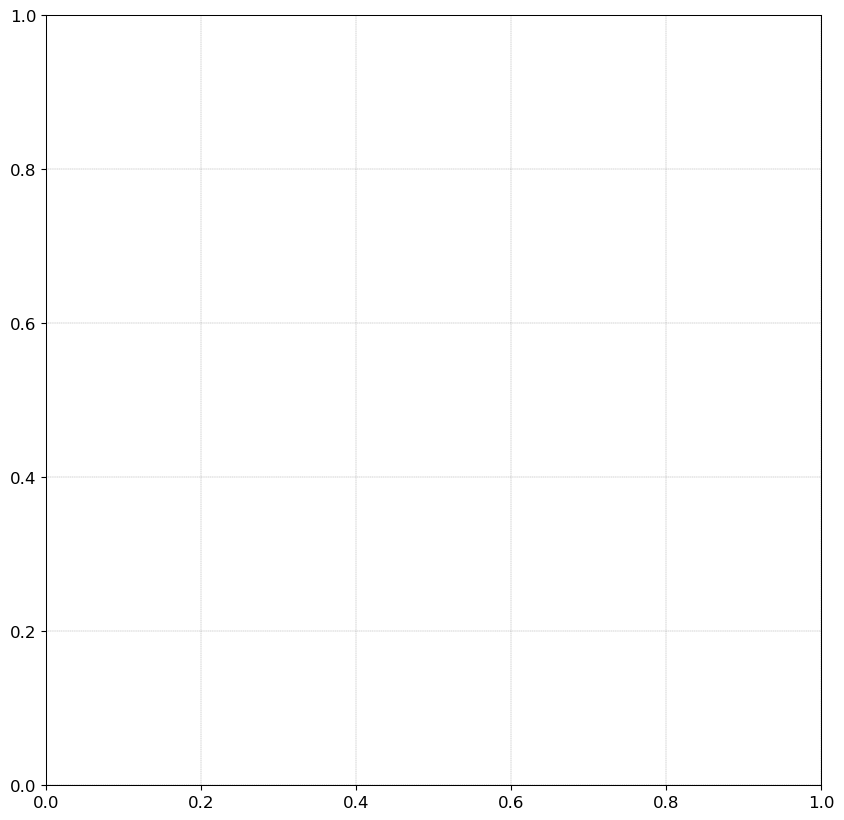

In [28]:
sw, sw_times = simu_solution.read_outputs('sw')
print(np.shape(sw))

fig, ax = plt.subplots()
for nn in nodeIds:
    ax.plot(sw.index,sw.iloc[:,nn],label=nn)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Saturation (-)')
plt.legend()

(add_noise_SMC)=
### Insert errors into the soil moisture

In [22]:
noise_std = 1e-2

In [23]:
SPP_df, FP_df =  simu_solution.read_inputs('soil',NVEG=1)
SPP_df.head()

PERMX     PERMY     PERMZ   ELSTOR  POROS  VGNCELL  VGRMCCELL  \
zone layer                                                                     
1    0      0.000188  0.000188  0.000188  0.00001   0.55     1.46       0.15   
     1      0.000188  0.000188  0.000188  0.00001   0.55     1.46       0.15   
     2      0.000188  0.000188  0.000188  0.00001   0.55     1.46       0.15   
     3      0.000188  0.000188  0.000188  0.00001   0.55     1.46       0.15   
     4      0.000188  0.000188  0.000188  0.00001   0.55     1.46       0.15   

            VGPSATCELL  
zone layer              
1    0         0.03125  
     1         0.03125  
     2         0.03125  
     3         0.03125  
     4         0.03125

In [24]:
POROS = SPP_df['POROS'].mean()
sw2SMC = sw*POROS

NameError: name 'sw' is not defined

In [25]:
noise = np.random.normal(loc=0, 
                         scale=noise_std, 
                         size=sw.shape
                        )  # introducing Gaussian noise with mean 0 and standard deviation 0.01
sw2SMC_with_errors = sw2SMC + noise

NameError: name 'sw' is not defined

NameError: name 'sw_times' is not defined

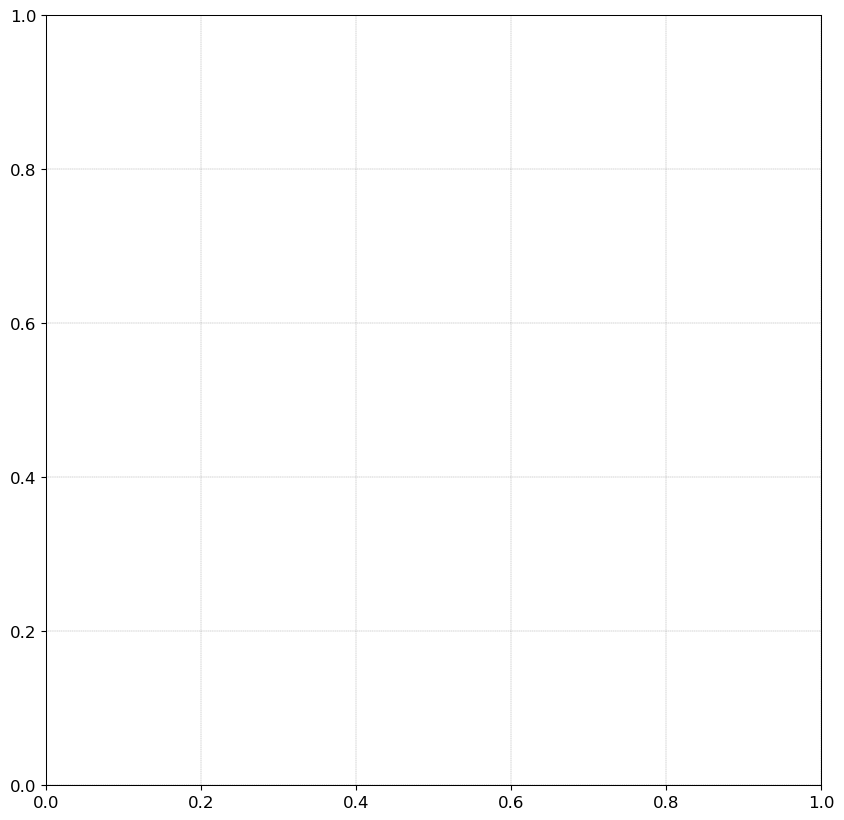

In [26]:
fig, ax = plt.subplots()
for nn in nodeIds:
    ax.plot(sw_times,sw2SMC_with_errors[:,nn],color='k')
    ax.plot(sw_times,sw2SMC[:,nn],marker='.',color='grey')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Soil Moisture Content (%)')

In [ ]:
# Round elements in sw_times to the nearest hundred ! this is a bug in the simulation
SMCtoAssimilate = np.hstack(sw2SMC_with_errors[:,nodeIds])
sw_times_rounded = [round(swt, -2) for swt in sw_times]
common_elements = sorted(set(sw_times_rounded) & set(tatmbc))
indices_sw_times = [sw_times_rounded.index(element) for element in common_elements]
sw_times_common_rounded = [sw_times_rounded[idx] for idx in indices_sw_times]
SMCtoAssimilate_common = SMCtoAssimilate[:, indices_sw_times]

In [ ]:
sensors_names = ['SMC'+str(i) for i in range(5)]

In [21]:
SMC_sensors_df = pd.DataFrame(SMCtoAssimilate_common,
                              columns=sw_times_common_rounded,
                              index=sensors_names
                             )
SMC_sensors_df = SMC_sensors_df.iloc[:, :-1] # drop duplicate collumn
SMC_sensors_df = SMC_sensors_df.T
SMC_sensors_df.head()

NameError: name 'SMCtoAssimilate_common' is not defined

(prep_DA)=
## 1. Prepare Data Assimilation

First we define a dictionnary `scenario` describing which and how of the model parameters are **perturbated** and **updated**. One example case is considered, where initial condition and root depth is perturbated and updated sequentially: 
`ic_ZROOT_upd_ZROOT`

:::{admonition} Feddes parameters perturbation
In order to perturbate Feddes parameters we use typical range of possible values. 
For **ZROOT** the perturbation must be bounded within the limit of the simulation region. 
This condition is applied thanks to the dictionnary key `per_bounds`.
:::

- `per_type`
- `per_name`
- `per_nom`
- `per_sigma`
- `sampling_type`


In [22]:
scenario = {
    
            # scenario without parameter update
            # -------------------------------------
            'ic_ZROOT_NOupdate': {'per_type': [None,None],
                                 'per_name':['ic', 'ZROOT'],
                                 'per_nom':[-1,0.4],
                                 'per_mean':[-1,0.4],    
                                 'per_sigma': [1.75,5e-3],
                                 'per_bounds': [None,{'min':0,'max':1.5}],
                                 'sampling_type': ['normal']*2,
                                 'transf_type':[None,None],
                                'listUpdateParm': ['St. var.'],
                                },
    
            # scenario with parameter update
            # -------------------------------------
            'ic_ZROOT_upd_ZROOT': 
                                                        {'per_type': [None,None], 
                                                         'per_name':['ic', 'ZROOT'],
                                                         'per_nom':[-1,0.4],
                                                         'per_mean':[-1,0.4],    
                                                         'per_sigma': [1.75,5e-3],
                                                         'per_bounds': [None,{'min':0,'max':1.5}],
                                                         'sampling_type': ['normal']*2,
                                                         'transf_type':[None,None],
                                                         'listUpdateParm': ['St. var.', 'ZROOT']
                                                         },    
            }
print(scenario)

{'ic_ZROOT_NOupdate': {'per_type': [None, None], 'per_name': ['ic', 'ZROOT'], 'per_nom': [-1, 0.4], 'per_mean': [-1, 0.4], 'per_sigma': [1.75, 0.005], 'per_bounds': [None, {'min': 0, 'max': 1.5}], 'sampling_type': ['normal', 'normal'], 'transf_type': [None, None], 'listUpdateParm': ['St. var.']}, 'ic_ZROOT_upd_ZROOT': {'per_type': [None, None], 'per_name': ['ic', 'ZROOT'], 'per_nom': [-1, 0.4], 'per_mean': [-1, 0.4], 'per_sigma': [1.75, 0.005], 'per_bounds': [None, {'min': 0, 'max': 1.5}], 'sampling_type': ['normal', 'normal'], 'transf_type': [None, None], 'listUpdateParm': ['St. var.', 'ZROOT']}}


(import_SMC_obs)=
### 2.1 Import SMC observations

```{tip}
    need to call `read_observations` as many times as variable to perturbate 
    return a dict merging all variable perturbate to parse into prepare_DA
```

In [23]:
# pts_data_err = 5e-3
pts_data_err = 1e99 # this correspond to the simulation "withoutDA"

In [24]:
dict_obs = {} # initiate the dictionnary
data_ass_time_s = sw_times
dict_obs

{}

`read_observations` takes as _mandatory arguments_: 
- `obs_2_add`: filename or value to add
- `mesh_nodes`: the closest mesh node where the sensor is located.

You can use ```nodeId, closest_pos = simu_solution.find_nearest_node(node_pos)```

- `data type`: 'swc'= soil water content. Options are: 'tensio' for tensiometers data, 'ERT' for electrical resistivity tomography data and others that you can check directly in the read_observations functions
- `tA`: assimilation time in second (**!this should be synchronise with atmbc times!**)
- `data_err`: absolute error of the sensor to consider

Optional arguments: 
- `colname`


In [25]:
dict_obs

{}

In [26]:
%%capture
for i in range(len(SMC_sensors_df.columns)):
    for j, tt in enumerate(SMC_sensors_df.index):
        dict_obs = read_observations( 
                                        dict_obs,
                                        obs_2_add=SMC_sensors_df['SMC'+str(i)].iloc[j], 
                                        mesh_nodes = nodeIds[i],
                                        data_type='swc',
                                        data_err=pts_data_err,
                                        #date_range=[args.startD,args.endD],
                                        colname=' m³/m³ Water Content',
                                        tA=tt
                                        )

In [27]:
data_measure_df = dictObs_2pd(dict_obs) 
data_measure_df.head()

filename data_type          units      data  \
sensorNameidx assimilation time                                               
swc           0.0                   None       swc  $m^{3}/m^{3}$  0.225760   
              9600.0                None       swc  $m^{3}/m^{3}$  0.328773   
              19200.0               None       swc  $m^{3}/m^{3}$  0.300614   
              28800.0               None       swc  $m^{3}/m^{3}$  0.290318   
              38400.0               None       swc  $m^{3}/m^{3}$  0.268523   

                                     data_err mesh_nodes  assimilation_times  \
sensorNameidx assimilation time                                                
swc           0.0                1.000000e+99      [220]                 0.0   
              9600.0             1.000000e+99      [220]              9600.0   
              19200.0            1.000000e+99      [220]             19200.0   
              28800.0            1.000000e+99      [220]             28800.0   
              38400.0            1.000000e+99      [220]             38400.0   

                                datetime data_cov dataPert sensor_name  
sensorNameidx assimilation time                                         
swc           0.0                   None       []       []         swc  
              9600.0                None       []       []         swc  
              19200.0               None       []       []         swc  
              28800.0               None       []       []         swc  
              38400.0               None       []       []         swc

#### 2.1.1 Create observation covariance matrice 

In [28]:
%%capture
data_cov, data_pert, stacked_data_cov = make_data_cov(
                                                        simuWithDA,
                                                        dict_obs,
                                                        list_assimilated_obs = 'all',
                                                        nb_assimilation_times=len(dict_obs)
                                                        )

simuWithDA.stacked_data_cov = stacked_data_cov

### 2.2 Perturbate

We first need to build the mesh

In [29]:
simuWithDA.update_soil()

🔄 Update soil

homogeneous soil

In [30]:
help(perturbate.perturbate)
NENS = 32
list_pert = perturbate.perturbate(
                                    simuWithDA, 
                                    scenario['ic_ZROOT_NOupdate'], 
                                    NENS,
                                 )

Help on function perturbate in module pyCATHY.DA.perturbate:

perturbate(simu_DA, scenario, NENS, pertControl='Layer')
    Write a list of dictionaries, each containing all the informations on how to
    perturbate the parameters based on the scenario to consider
    
    
    pertControl = 'Layer'        
    Perturbation per zone is not yet implemented -  Assuming that the 
    dictionnary of perturbated parameters is build per layers i.e. 
    ks0= layer 0, ks1=layer 1, etc...



In [31]:
simuWithDA.project_name

'Weill_example_withoutDA'

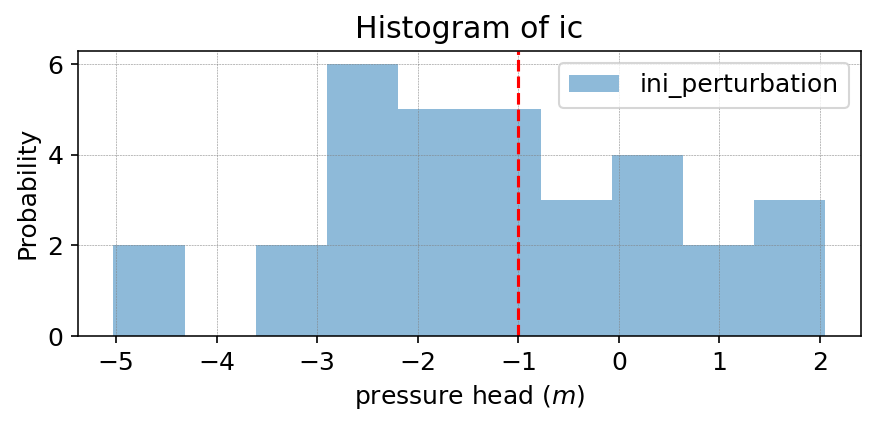

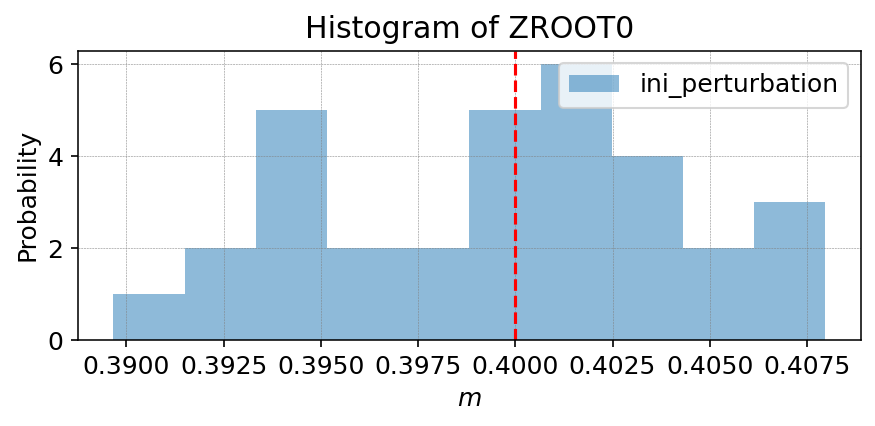

In [32]:
var_per_dict_stacked = {}
for dp in list_pert:
    # need to call perturbate_var as many times as variable to perturbate
    # return a dict merging all variable perturbate to parse into prepare_DA
    var_per_dict_stacked = perturbate_parm(
                                var_per_dict_stacked,
                                parm=dp, 
                                type_parm = dp['type_parm'], # can also be VAN GENUCHTEN PARAMETERS
                                mean =  dp['mean'],
                                sd =  dp['sd'],
                                sampling_type =  dp['sampling_type'],
                                ensemble_size =  dp['ensemble_size'], # size of the ensemble
                                per_type= dp['per_type'],
                                savefig= os.path.join(simuWithDA.workdir,
                                                      simuWithDA.project_name,
                                                      simuWithDA.project_name + dp['savefig'])
                                )

### 2.3 Define mapping operator 
For assimilation of soil moisture content data, the default mapping to get the water saturation is: porosity*SM
Please refer to ?? to see the mapping tools of pyCATHY

(solve)=
### 3. Run sequential DA

Simply use `run_DA_sequential()` with the `simu_DA` object

Required arguments are:
- **dict_obs**: dictionnary of observations
- **list_assimilated_obs**: list of observation to assimilate 
- **list_parm2update**: list of parameters to update 

Possible **optionnal** arguments are: 
- **parallel**: if True use multiple cores to run many realisations at the same time
- **DA_type**: type of data assimilation
- **threshold_rejected**: threshold above which the simulation stops (i.e. ensemble of rejected realisation too big)
- **damping**: add damping to inflate the covariance matrice


```{tip}
    During the execution **useful informations are displayed on the console** in order to follow the state of the DA. You can for example appreciated how many ensemble are rejected.
```


In [33]:
parallel = True

In [34]:
simuWithDA.update_parm(
                        IPRT1=2,
                        TRAFLAG=0,
                        DTMIN=1e-2,DTMAX=1e3,DELTAT=1
                        )

🔄 update parm file 

In [35]:
simuWithDA.run_DA_sequential(
                              parallel=parallel,    
                              dict_obs= dict_obs,
                              list_assimilated_obs='all', # default
                              list_parm2update=scenario['ic_ZROOT_NOupdate']['listUpdateParm'],
                              DA_type='enkf_Evensen2009_Sakov',
                              dict_parm_pert=var_per_dict_stacked,
                              open_loop_run=False,
                              threshold_rejected=80,
                              # damping=1                   
                            )

🔄 update parm file 

🛠  Recompile src files [146s]

🍳 gfortran compilation [150s]

b''

Archie parameters not defined set defaults


─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Archie parameters not defined - Falling back to defaults

VGN parameters not defined - Falling back to defaults

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🔄 Update ensemble

🍳 gfortran compilation

👟 Run preprocessor

🔄 update parm file 

🛠  Recompile src files [153s]

🍳 gfortran compilation [157s]

b''

👟 Run processor

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

🧽 update input ensemble

🔄 update parm file 

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

['Adjusting NPRT with respect to time of interests requested\n']

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 Update ensemble

👟 Run hydrological model

✅ check scenarii before analysis

❌ df_mbeconv['time']0.02, ens_nb:5

❌ df_mbeconv['time']0.0725, ens_nb:15

cannot read mbeconv


❌ df_mbeconv['time']0.0725, ens_nb:22

❌ df_mbeconv['time']0.025625, ens_nb:23

❌ df_mbeconv['time']0.025625, ens_nb:25

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (5,)
                                 --> Observations --> all

parm size: 0


SakovTrue

🧐 check analysis performance

!positive pressure heads observed!


✅ check scenarii post update

─────────────────────────────────────── 📍 end of time step (s) 0/86400 📍 ────────────────────────────────────────

───────────────────────────────────────── 📍 end of atmbc update # 1/9 📍 ─────────────────────────────────────────

🧽 update input ensemble

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 Update ensemble

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

─────────────────────────────────────────── 🔴 end of DA update 1/9 🔴 ────────────────────────────────────────────

───────────────────────────────────────── 🎯 % of valid ensemble: 81.25🎯 ─────────────────────────────────────────

👟 Run hydrological model

✅ check scenarii before analysis

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (5,)
                                 --> Observations --> all

parm size: 0


SakovTrue

🧐 check analysis performance

!positive pressure heads observed!


✅ check scenarii post update

────────────────────────────────────── 📍 end of time step (s) 9600/86400 📍 ──────────────────────────────────────

───────────────────────────────────────── 📍 end of atmbc update # 2/9 📍 ─────────────────────────────────────────

🧽 update input ensemble

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 Update ensemble

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

─────────────────────────────────────────── 🔴 end of DA update 2/9 🔴 ────────────────────────────────────────────

───────────────────────────────────────── 🎯 % of valid ensemble: 81.25🎯 ─────────────────────────────────────────

👟 Run hydrological model

✅ check scenarii before analysis

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (5,)
                                 --> Observations --> all

parm size: 0


SakovTrue

🧐 check analysis performance

!positive pressure heads observed!


✅ check scenarii post update

───────────────────────────────────── 📍 end of time step (s) 19200/86400 📍 ──────────────────────────────────────

───────────────────────────────────────── 📍 end of atmbc update # 3/9 📍 ─────────────────────────────────────────

🧽 update input ensemble

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 Update ensemble

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

─────────────────────────────────────────── 🔴 end of DA update 3/9 🔴 ────────────────────────────────────────────

───────────────────────────────────────── 🎯 % of valid ensemble: 81.25🎯 ─────────────────────────────────────────

👟 Run hydrological model

✅ check scenarii before analysis

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (5,)
                                 --> Observations --> all

parm size: 0


SakovTrue

🧐 check analysis performance

!positive pressure heads observed!


✅ check scenarii post update

───────────────────────────────────── 📍 end of time step (s) 28800/86400 📍 ──────────────────────────────────────

───────────────────────────────────────── 📍 end of atmbc update # 4/9 📍 ─────────────────────────────────────────

🧽 update input ensemble

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 Update ensemble

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

─────────────────────────────────────────── 🔴 end of DA update 4/9 🔴 ────────────────────────────────────────────

───────────────────────────────────────── 🎯 % of valid ensemble: 81.25🎯 ─────────────────────────────────────────

👟 Run hydrological model

✅ check scenarii before analysis

❌ df_mbeconv['time']6167.364, ens_nb:1

❌ df_mbeconv['time']6368.009, ens_nb:7

❌ df_mbeconv['time']6084.324, ens_nb:11

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (5,)
                                 --> Observations --> all

parm size: 0


SakovTrue

🧐 check analysis performance

!positive pressure heads observed!


✅ check scenarii post update

───────────────────────────────────── 📍 end of time step (s) 38400/86400 📍 ──────────────────────────────────────

───────────────────────────────────────── 📍 end of atmbc update # 5/9 📍 ─────────────────────────────────────────

🧽 update input ensemble

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 Update ensemble

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

─────────────────────────────────────────── 🔴 end of DA update 5/9 🔴 ────────────────────────────────────────────

──────────────────────────────────────── 🎯 % of valid ensemble: 71.875🎯 ─────────────────────────────────────────

👟 Run hydrological model

✅ check scenarii before analysis

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (5,)
                                 --> Observations --> all

parm size: 0


SakovTrue

🧐 check analysis performance

!positive pressure heads observed!


✅ check scenarii post update

───────────────────────────────────── 📍 end of time step (s) 48000/86400 📍 ──────────────────────────────────────

───────────────────────────────────────── 📍 end of atmbc update # 6/9 📍 ─────────────────────────────────────────

🧽 update input ensemble

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 Update ensemble

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

─────────────────────────────────────────── 🔴 end of DA update 6/9 🔴 ────────────────────────────────────────────

──────────────────────────────────────── 🎯 % of valid ensemble: 71.875🎯 ─────────────────────────────────────────

👟 Run hydrological model

✅ check scenarii before analysis

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (5,)
                                 --> Observations --> all

parm size: 0


SakovTrue

🧐 check analysis performance

!positive pressure heads observed!


✅ check scenarii post update

───────────────────────────────────── 📍 end of time step (s) 57600/86400 📍 ──────────────────────────────────────

───────────────────────────────────────── 📍 end of atmbc update # 7/9 📍 ─────────────────────────────────────────

🧽 update input ensemble

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 Update ensemble

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

─────────────────────────────────────────── 🔴 end of DA update 7/9 🔴 ────────────────────────────────────────────

──────────────────────────────────────── 🎯 % of valid ensemble: 71.875🎯 ─────────────────────────────────────────

👟 Run hydrological model

✅ check scenarii before analysis

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (5,)
                                 --> Observations --> all

parm size: 0


SakovTrue

🧐 check analysis performance

!positive pressure heads observed!


✅ check scenarii post update

───────────────────────────────────── 📍 end of time step (s) 67200/86400 📍 ──────────────────────────────────────

───────────────────────────────────────── 📍 end of atmbc update # 8/9 📍 ─────────────────────────────────────────

🧽 update input ensemble

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 Update ensemble

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

─────────────────────────────────────────── 🔴 end of DA update 8/9 🔴 ────────────────────────────────────────────

──────────────────────────────────────── 🎯 % of valid ensemble: 71.875🎯 ─────────────────────────────────────────

👟 Run hydrological model

✅ check scenarii before analysis

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

Transform sat to SWC with porosity=' [0.55]

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

Current implementation does not support different porosity zones! 
            Only layers porosity is considered - Taking zone 1 as default
        

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (5,)
                                 --> Observations --> all

parm size: 0


SakovTrue

🧐 check analysis performance

!positive pressure heads observed!


✅ check scenarii post update

───────────────────────────────────── 📍 end of time step (s) 76800/86400 📍 ──────────────────────────────────────

───────────────────────────────────────── 📍 end of atmbc update # 9/9 📍 ─────────────────────────────────────────

───────────────────────────────────────────────── 🔴 end of DA🔴 ──────────────────────────────────────────────────

─────────────────────────────────────────── 🔴 end of DA update 9/9 🔴 ────────────────────────────────────────────

──────────────────────────────────────── 🎯 % of valid ensemble: 71.875🎯 ─────────────────────────────────────────

👟 Run hydrological model

✅ check scenarii before analysis

😕 No observation for this time - run hydrological model only

!shortcut here ensemble are not validated!
!shortcut here ensemble are not validated!
max, min, mean sw: 
                      3.08087, 
                      -214.1262, 
                      -1.7872942243826975
                      


───────────────────────────────────── 📍 end of time step (s) 86400/86400 📍 ──────────────────────────────────────

──────────────────────────────────────── 📍 end of atmbc update # 10/9 📍 ─────────────────────────────────────────

───────────────────────────────────────────────── 🔴 end of DA🔴 ──────────────────────────────────────────────────

─────────────────────────────────────────── 🔴 end of DA update 9/9 🔴 ────────────────────────────────────────────

──────────────────────────────────────── 🎯 % of valid ensemble: 71.875🎯 ─────────────────────────────────────────